In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import textwrap
import nbformat
from sqlalchemy import create_engine
from sqlalchemy import text
import sqlite3
import psycopg2

In [42]:
# Database Credentials
user = "postgres"
password = "123456"
db_name = "crop_production_prediction"
host = "localhost"

# Defining Engine to Push data using SQLAlchemy
sa_conn = f"postgresql://{user}:{password}@{host}/{db_name}"
engine = create_engine(sa_conn)

In [43]:
df = pd.read_csv('cleaned_df.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df

,Country,Item,Year,production_in_t,area_in_h,yield_in_kg_per_h,Category
0,Afghanistan,"Almonds, in shell",2020,39307.0,22134.0,1776.0,Nuts
1,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2019,17808.0,25293.0,704.0,Spices
2,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2020,17966.0,25558.0,703.0,Spices
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2021,17876.0,25357.0,705.0,Spices
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2022,17883.0,25403.0,704.0,Spices
...,...,...,...,...,...,...,...
31001,Zimbabwe,Watermelons,2019,92975.0,3719.0,25000.0,Fruits
31002,Zimbabwe,Watermelons,2021,139000.0,4430.0,31377.0,Fruits
31003,Zimbabwe,Watermelons,2022,162100.0,4790.0,33841.0,Fruits
31004,Zimbabwe,Watermelons,2023,150600.0,4610.0,32668.0,Fruits


In [44]:
df['Item_wrapped'] = df['Item'].apply(lambda x: textwrap.fill(x, width=12))

In [45]:
cultivation = df[['Country','Item_wrapped','Year','area_in_h']].groupby(['Country','Item_wrapped','Year'])['area_in_h'].sum().reset_index().sort_values('area_in_h', ascending=False)
cultivation_year = cultivation.query("Year==2023")
cultivation_year

,Country,Item_wrapped,Year,area_in_h
5259,China,Apricots,2023,157020.0
5294,China,"Pepper\n(Piper\nspp.), raw",2023,151376.0
5269,China,Cereals\nn.e.c.,2023,144456.0
5264,China,"Broad beans\nand horse\nbeans, green",2023,79824.0
5279,China,Leeks and\nother\nalliaceous\nvegetables,2023,42388.0
...,...,...,...,...
24243,Singapore,"Cassava,\nfresh",2023,0.0
22160,Republic of Korea,Castor oil\nseeds,2023,0.0
18405,Nauru,Tomatoes,2023,0.0
18365,Nauru,Eggplants\n(aubergines),2023,0.0


In [46]:
cultivation_year_df = cultivation_year.groupby('Country')['area_in_h'].sum().reset_index(name='total_area').sort_values('total_area',ascending=False)

In [47]:
top_10_countries = cultivation_year_df.nlargest(10,'total_area')
bottom_10_countries = cultivation_year_df.nsmallest(10,'total_area')

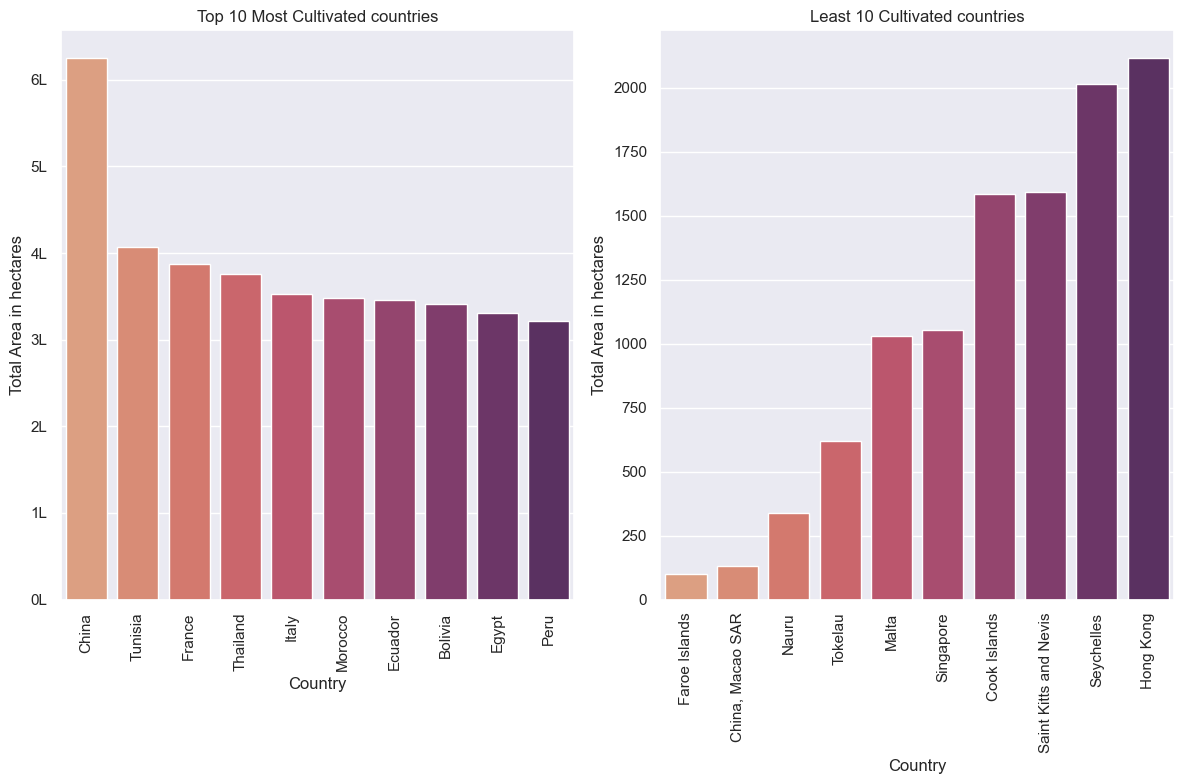

In [48]:
fig, ax = plt.subplots(1,2,figsize = (12,8))
sns.barplot(
    data = top_10_countries,
    x = 'Country',
    y = 'total_area',
    errorbar = None,
    palette = 'flare',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated countries")
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_ylabel('Total Area in hectares')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}L'))

sns.barplot(
    data = bottom_10_countries,
    x = 'Country',
    y = 'total_area',
    errorbar = None,
    palette = 'flare'
)
ax[1].set_title("Least 10 Cultivated countries")
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_ylabel('Total Area in hectares')

plt.tight_layout()
plt.show()

In [49]:
production = df[['Country','Item','Year','production_in_t']].groupby(['Country','Item','Year'])['production_in_t'].sum().reset_index().sort_values('production_in_t', ascending=False)
production_year = production.query("Year==2023")
production_year_df = production_year.groupby('Country')['production_in_t'].sum().reset_index(name='total_production').sort_values('total_production',ascending=False)

In [50]:
yield_df = df[['Country','Item','Year','yield_in_kg_per_h']].groupby(['Country','Item','Year'])['yield_in_kg_per_h'].sum().reset_index().sort_values('yield_in_kg_per_h', ascending=False)
yield_year = yield_df.query("Year==2023")
yield_year_df = yield_year.groupby('Country')['yield_in_kg_per_h'].sum().reset_index(name='total_yield').sort_values('total_yield',ascending=False)

In [51]:
top_10_countries_production = production_year_df.nlargest(10,'total_production')
bottom_10_countries_production = production_year_df.nsmallest(10,'total_production')

top_10_countries_yield = yield_year_df.nlargest(10,'total_yield')
bottom_10_countries_yield = yield_year_df.nsmallest(10,'total_yield')

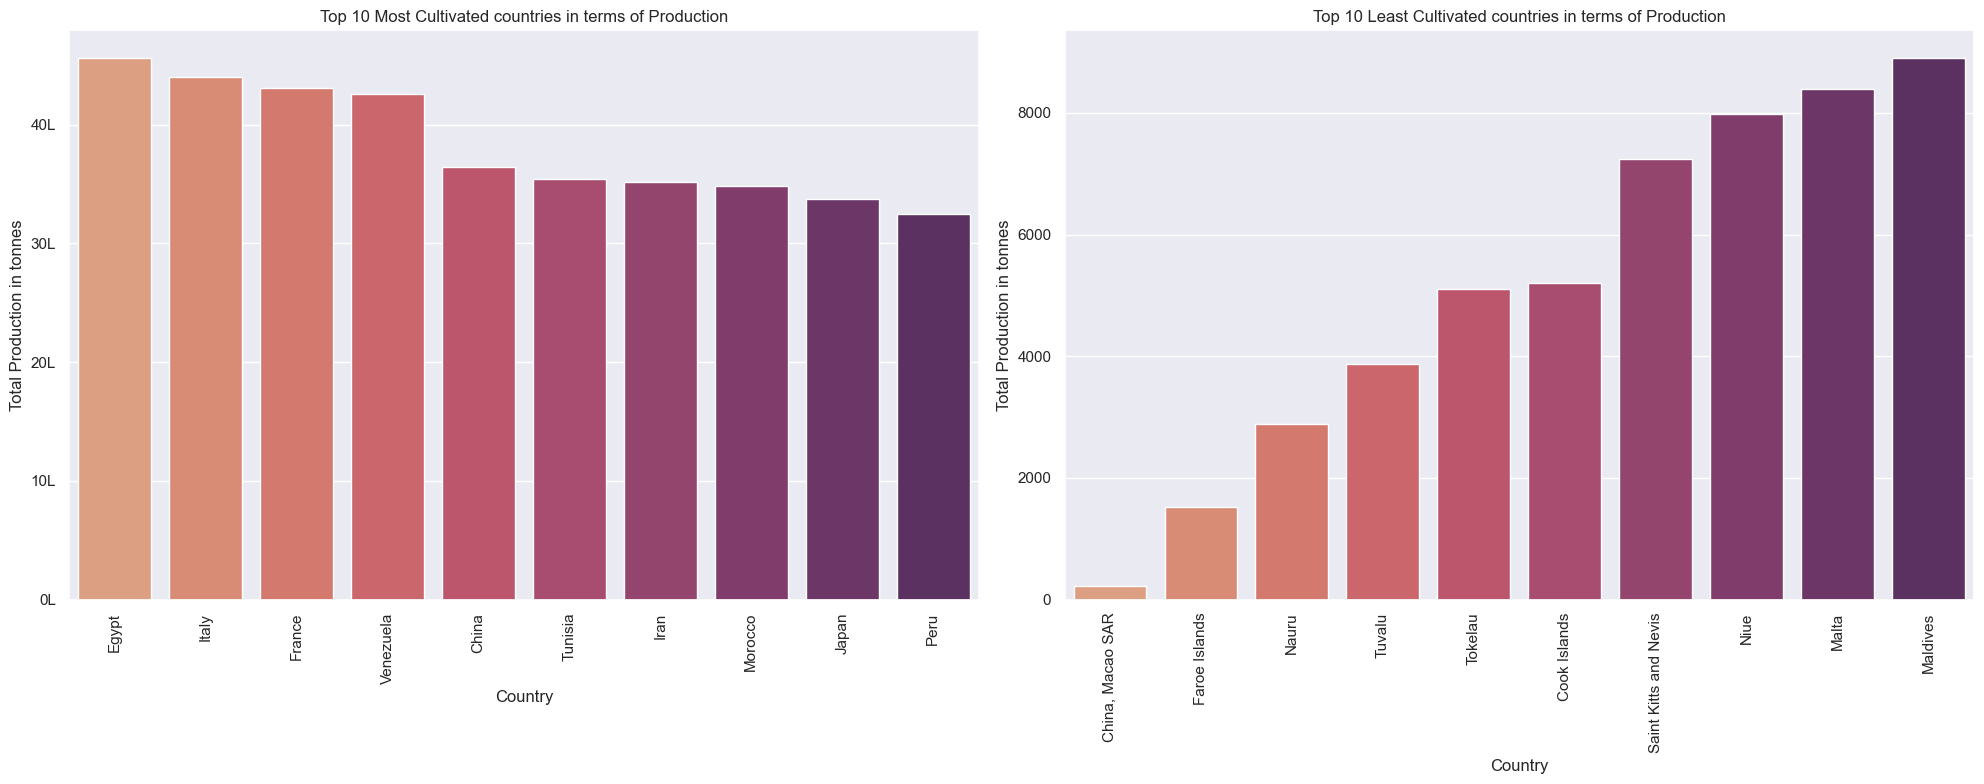

In [52]:
fig, ax = plt.subplots(1,2,figsize = (20,8))
sns.barplot(
    data = top_10_countries_production,
    x = 'Country',
    y = 'total_production',
    errorbar = None,
    palette = 'flare',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated countries in terms of Production")
ax[0].tick_params(axis='x', labelrotation=90)
# ax[0].set_yscale('log')
ax[0].set_ylabel('Total Production in tonnes')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}L'))

sns.barplot(
    data = bottom_10_countries_production,
    x = 'Country',
    y = 'total_production',
    errorbar = None,
    palette = 'flare',
    ax = ax[1]
)
ax[1].set_title("Top 10 Least Cultivated countries in terms of Production")
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_ylabel('Total Production in tonnes')

plt.tight_layout()
plt.show()

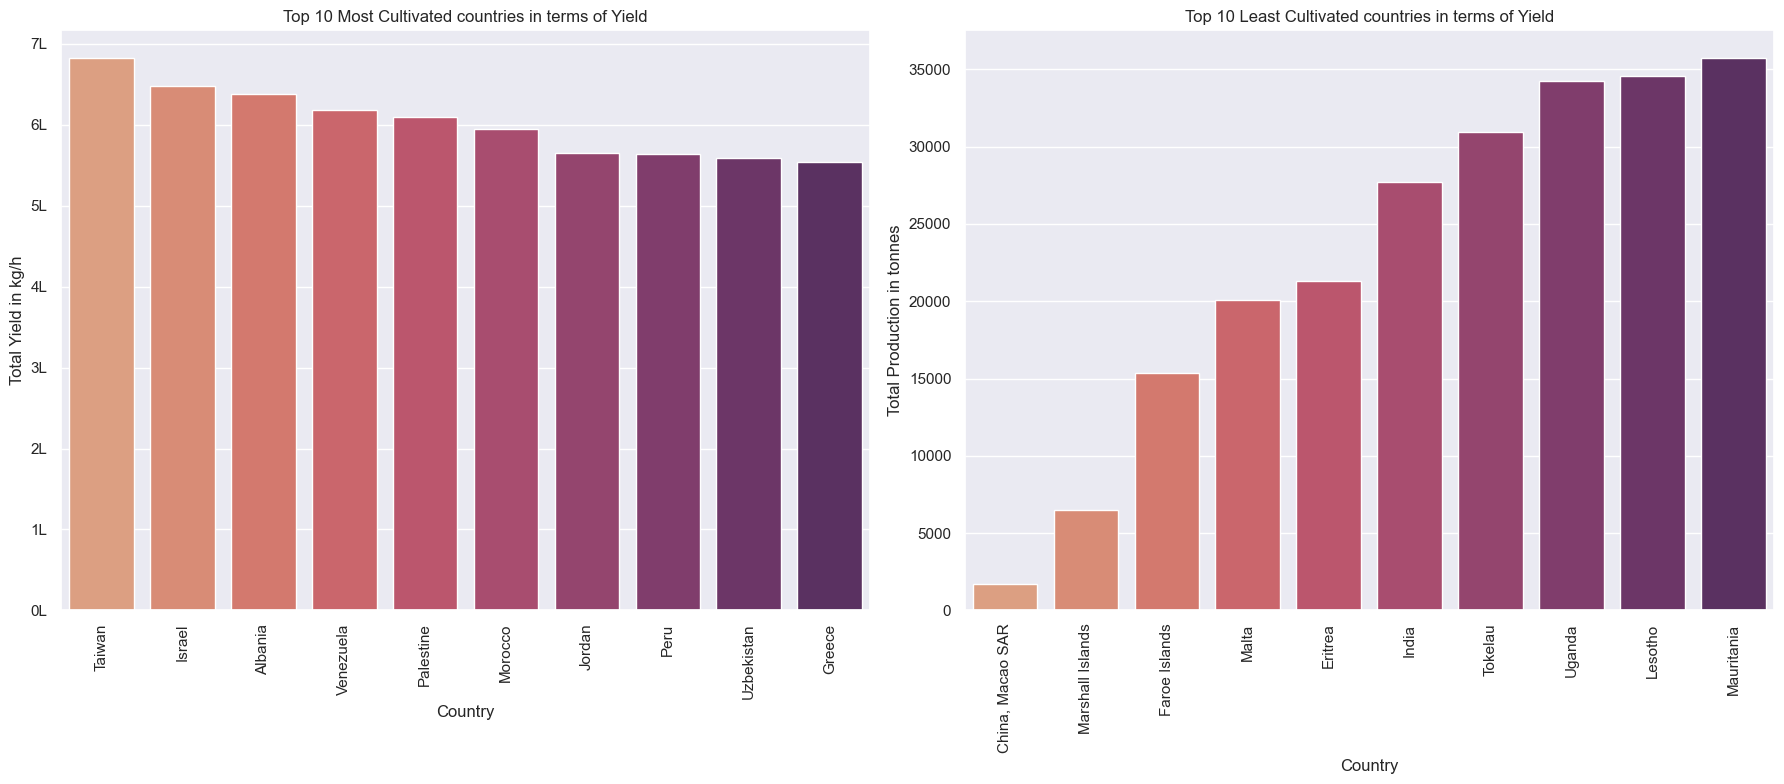

In [53]:
fig, ax = plt.subplots(1,2,figsize = (18,8))
sns.barplot(
    data = top_10_countries_yield,
    x = 'Country',
    y = 'total_yield',
    errorbar = None,
    palette = 'flare',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated countries in terms of Yield")
ax[0].tick_params(axis='x', labelrotation=90)
# ax[0].set_yscale('log')
ax[0].set_ylabel('Total Yield in kg/h')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}L'))

sns.barplot(
    data = bottom_10_countries_yield,
    x = 'Country',
    y = 'total_yield',
    errorbar = None,
    palette = 'flare',
    ax = ax[1]
)
ax[1].set_title("Top 10 Least Cultivated countries in terms of Yield")
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_ylabel('Total Production in tonnes')

plt.tight_layout()
plt.show()

In [54]:
year_df = df[['Year','production_in_t','area_in_h','yield_in_kg_per_h']]


In [55]:
year_production_df = year_df.groupby('Year')['production_in_t'].sum().reset_index(name ='total_production')
year_area_df = year_df.groupby('Year')['area_in_h'].sum().reset_index(name ='total_area')
year_yield_df = year_df.groupby('Year')['yield_in_kg_per_h'].sum().reset_index(name ='total_yield')

In [56]:
year_production_df

,Year,total_production
0,2019,216357340.0
1,2020,214954318.0
2,2021,216554020.0
3,2022,213597908.0
4,2023,210334728.0


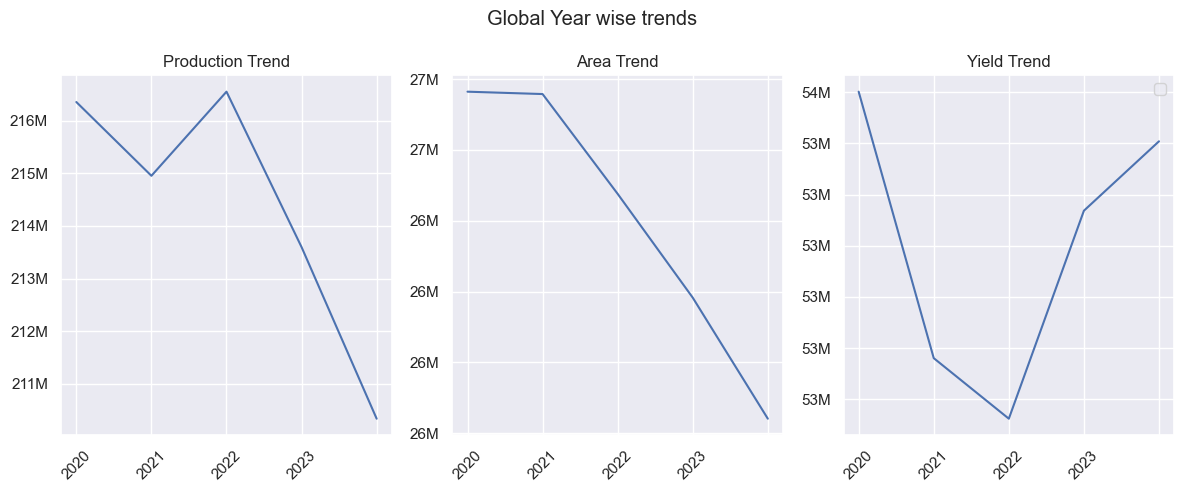

In [57]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].plot(year_production_df['Year'],year_production_df['total_production'])
ax[0].set_title('Production Trend')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[0].set_xticklabels(year_production_df['Year'].astype(int), rotation=45)


ax[1].plot(year_area_df['Year'],year_area_df['total_area'])
ax[1].set_title('Area Trend')
ax[1].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[1].set_xticklabels(year_area_df['Year'].astype(int), rotation=45)


ax[2].plot(year_yield_df['Year'],year_yield_df['total_yield'])
ax[2].set_title('Yield Trend')
ax[2].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[2].set_xticklabels(year_yield_df['Year'].astype(int), rotation=45)

plt.suptitle('Global Year wise trends')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
crop_area = df[['Country','Item_wrapped','Year','area_in_h','Category']].groupby(['Country','Item_wrapped','Year','Category'])['area_in_h'].sum().reset_index(name='total_area').sort_values('total_area', ascending=False)
crop_area_year = crop_area.query("Year==2023")
crop_area_year

,Country,Item_wrapped,Year,Category,total_area
5259,China,Apricots,2023,Fruits,157020.0
5294,China,"Pepper\n(Piper\nspp.), raw",2023,Spices,151376.0
5269,China,Cereals\nn.e.c.,2023,Cereals,144456.0
5264,China,"Broad beans\nand horse\nbeans, green",2023,Vegetables,79824.0
5279,China,Leeks and\nother\nalliaceous\nvegetables,2023,Vegetables,42388.0
...,...,...,...,...,...
24243,Singapore,"Cassava,\nfresh",2023,Vegetables,0.0
22160,Republic of Korea,Castor oil\nseeds,2023,Nuts,0.0
18405,Nauru,Tomatoes,2023,Vegetables,0.0
18365,Nauru,Eggplants\n(aubergines),2023,Vegetables,0.0


In [59]:
crop_area_year = crop_area_year[crop_area_year['total_area']>0]

top_crops_area = crop_area_year.nlargest(10,'total_area')

bottom_crops_area = crop_area_year.nsmallest(10,'total_area')


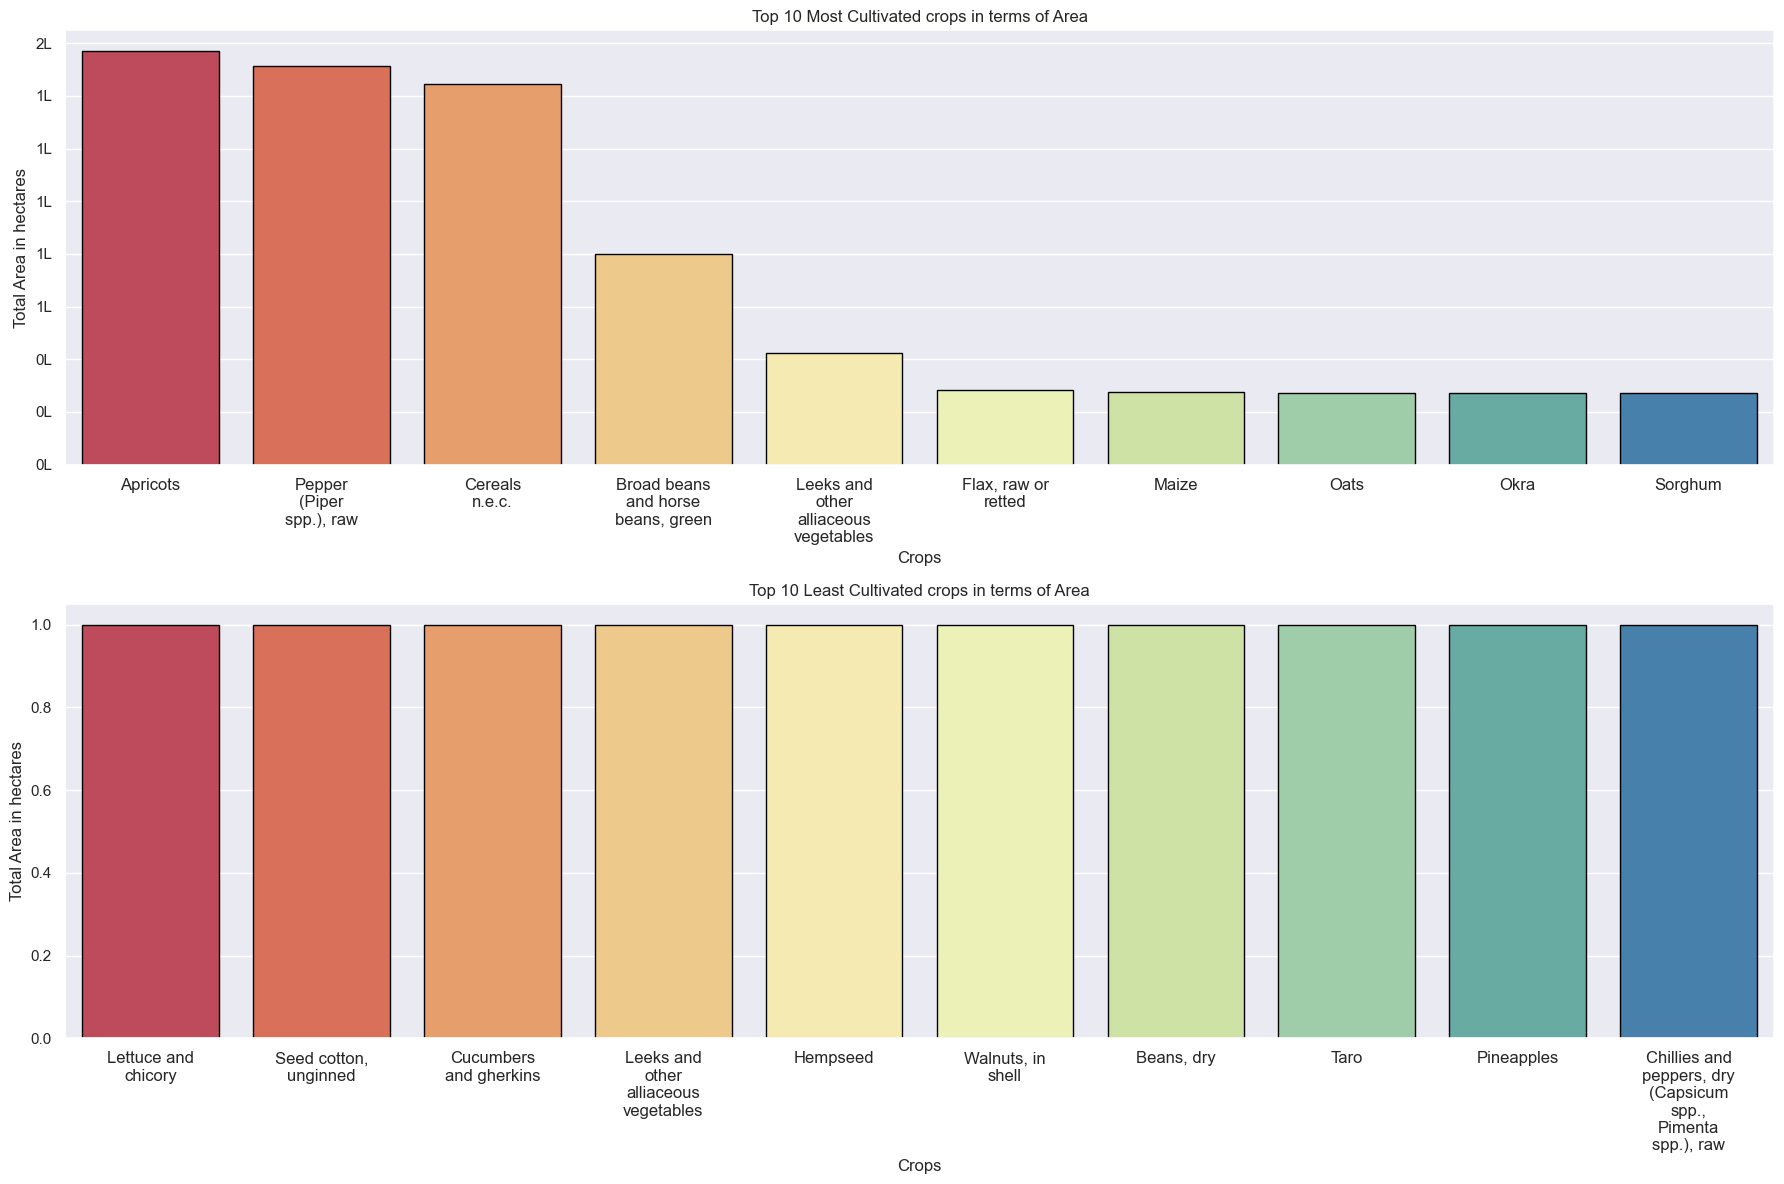

In [60]:
fig, ax = plt.subplots(2,1,figsize = (18,12))
sns.barplot(
    data = top_crops_area,
    x = 'Item_wrapped',
    y = 'total_area',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated crops in terms of Area")
ax[0].tick_params(axis='x', labelrotation=0,labelsize=12)
# ax[0].set_yscale('log')
ax[0].set_ylabel('Total Area in hectares')
ax[0].set_xlabel('Crops')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}L'))

sns.barplot(
    data = bottom_crops_area,
    x = 'Item_wrapped',
    y = 'total_area',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[1]
)
ax[1].set_title("Top 10 Least Cultivated crops in terms of Area")
ax[1].tick_params(axis='x', labelrotation=0,labelsize=12)
ax[1].set_ylabel('Total Area in hectares')
ax[1].set_xlabel('Crops')

plt.tight_layout()
plt.show()

In [61]:
crop_production = df[['Country','Item_wrapped','Year','production_in_t','Category']]
crop_production = crop_production.groupby(['Country','Item_wrapped','Year','Category'])['production_in_t'].sum().reset_index(name='total_production').sort_values('total_production', ascending=False)
crop_production_year = crop_production.query("Year==2023")
crop_production_year

,Country,Item_wrapped,Year,Category,total_production
5264,China,"Broad beans\nand horse\nbeans, green",2023,Vegetables,1241112.0
5279,China,Leeks and\nother\nalliaceous\nvegetables,2023,Vegetables,1051424.0
13506,Japan,Onions,2023,Vegetables,504723.0
26336,Syrian Arab Republic,Oranges,2023,Fruits,502244.0
9339,Finland,Potatoes,2023,Vegetables,498100.0
...,...,...,...,...,...
18380,Nauru,Okra,2023,Vegetables,0.0
22349,Republic of Moldova,Buckwheat,2023,Seeds,0.0
18370,Nauru,Lettuce and\nchicory,2023,Vegetables,0.0
5857,Cook Islands,"Coffee,\ngreen",2023,Cash crops,0.0


In [62]:
crop_production_year = crop_production_year[crop_production_year['total_production']>0]

top_crops_production = crop_production_year.nlargest(10,'total_production')

bottom_crops_production = crop_production_year.nsmallest(10,'total_production')


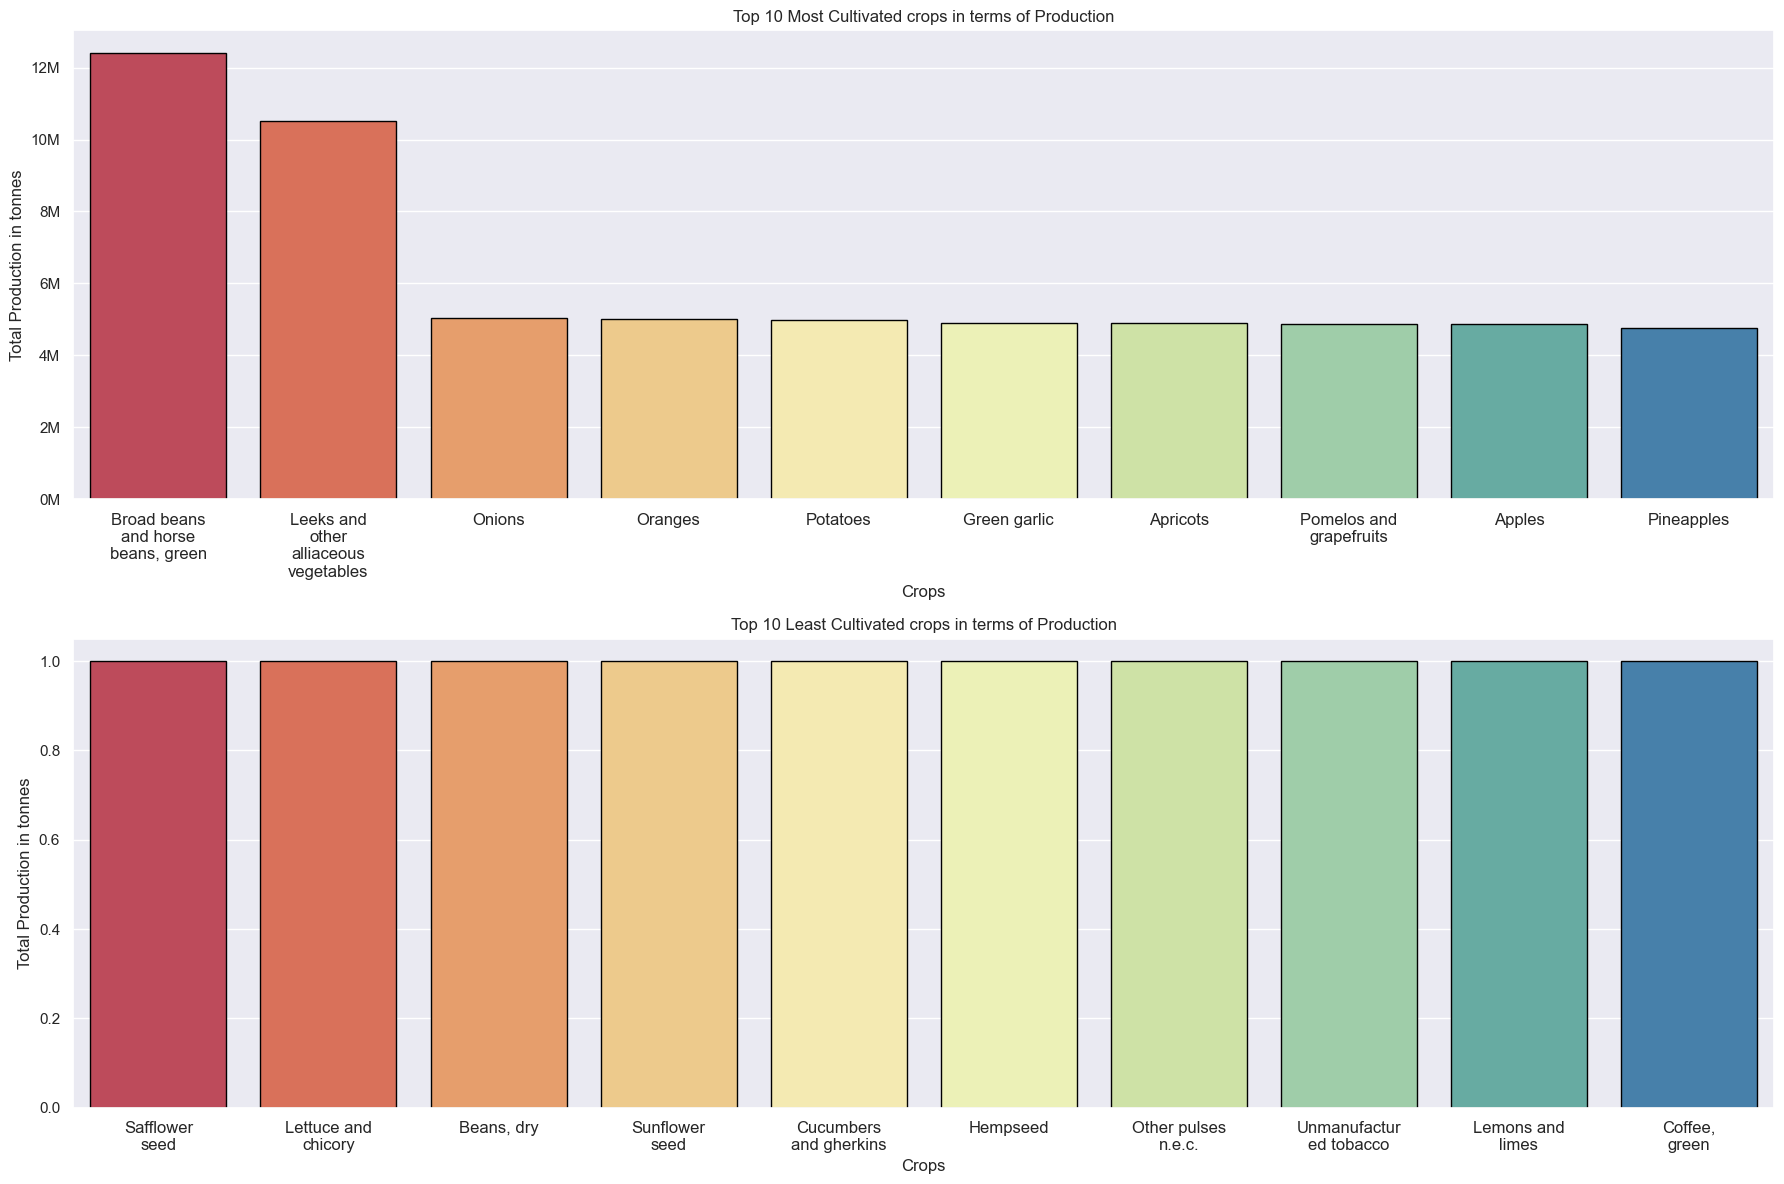

In [63]:
fig, ax = plt.subplots(2,1,figsize = (18,12))
sns.barplot(
    data = top_crops_production,
    x = 'Item_wrapped',
    y = 'total_production',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated crops in terms of Production")
ax[0].tick_params(axis='x', labelrotation=0,labelsize=12)
# ax[0].set_yscale('log')
ax[0].set_ylabel('Total Production in tonnes')
ax[0].set_xlabel('Crops')
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}M'))

sns.barplot(
    data = bottom_crops_production,
    x = 'Item_wrapped',
    y = 'total_production',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[1]
)
ax[1].set_title("Top 10 Least Cultivated crops in terms of Production")
ax[1].tick_params(axis='x', labelrotation=0,labelsize=12)
ax[1].set_ylabel('Total Production in tonnes')
ax[1].set_xlabel('Crops')

plt.tight_layout()
plt.show()

In [64]:
crop_yield = df[['Country','Item_wrapped','Year','yield_in_kg_per_h','Category']]
crop_yield = crop_yield.groupby(['Country','Item_wrapped','Year','Category'])['yield_in_kg_per_h'].sum().reset_index(name='total_yield').sort_values('total_yield', ascending=False)
crop_yield_year = crop_yield.query("Year==2023")
crop_yield_year

,Country,Item_wrapped,Year,Category,total_yield
5279,China,Leeks and\nother\nalliaceous\nvegetables,2023,Vegetables,198280.0
5264,China,"Broad beans\nand horse\nbeans, green",2023,Vegetables,134816.0
27802,Tunisia,Onions,2023,Vegetables,58501.0
15494,Libya,Onions,2023,Vegetables,50645.0
226,Albania,Onions,2023,Vegetables,43961.0
...,...,...,...,...,...
18788,New Caledonia,Other pulses\nn.e.c.,2023,Pulses,11.0
53,Afghanistan,"Other\nstimulant,\nspice and\naromatic\ncrops,...",2023,Spices,2.0
24478,Slovenia,"Almonds, in\nshell",2023,Nuts,0.0
15686,Lithuania,Other stone\nfruits,2023,Fruits,0.0


In [65]:
crop_yield_year = crop_yield_year[crop_yield_year['total_yield']>0]

top_crops_yield = crop_yield_year.nlargest(21,'total_yield')

bottom_crops_yield = crop_yield_year.nsmallest(13,'total_yield')

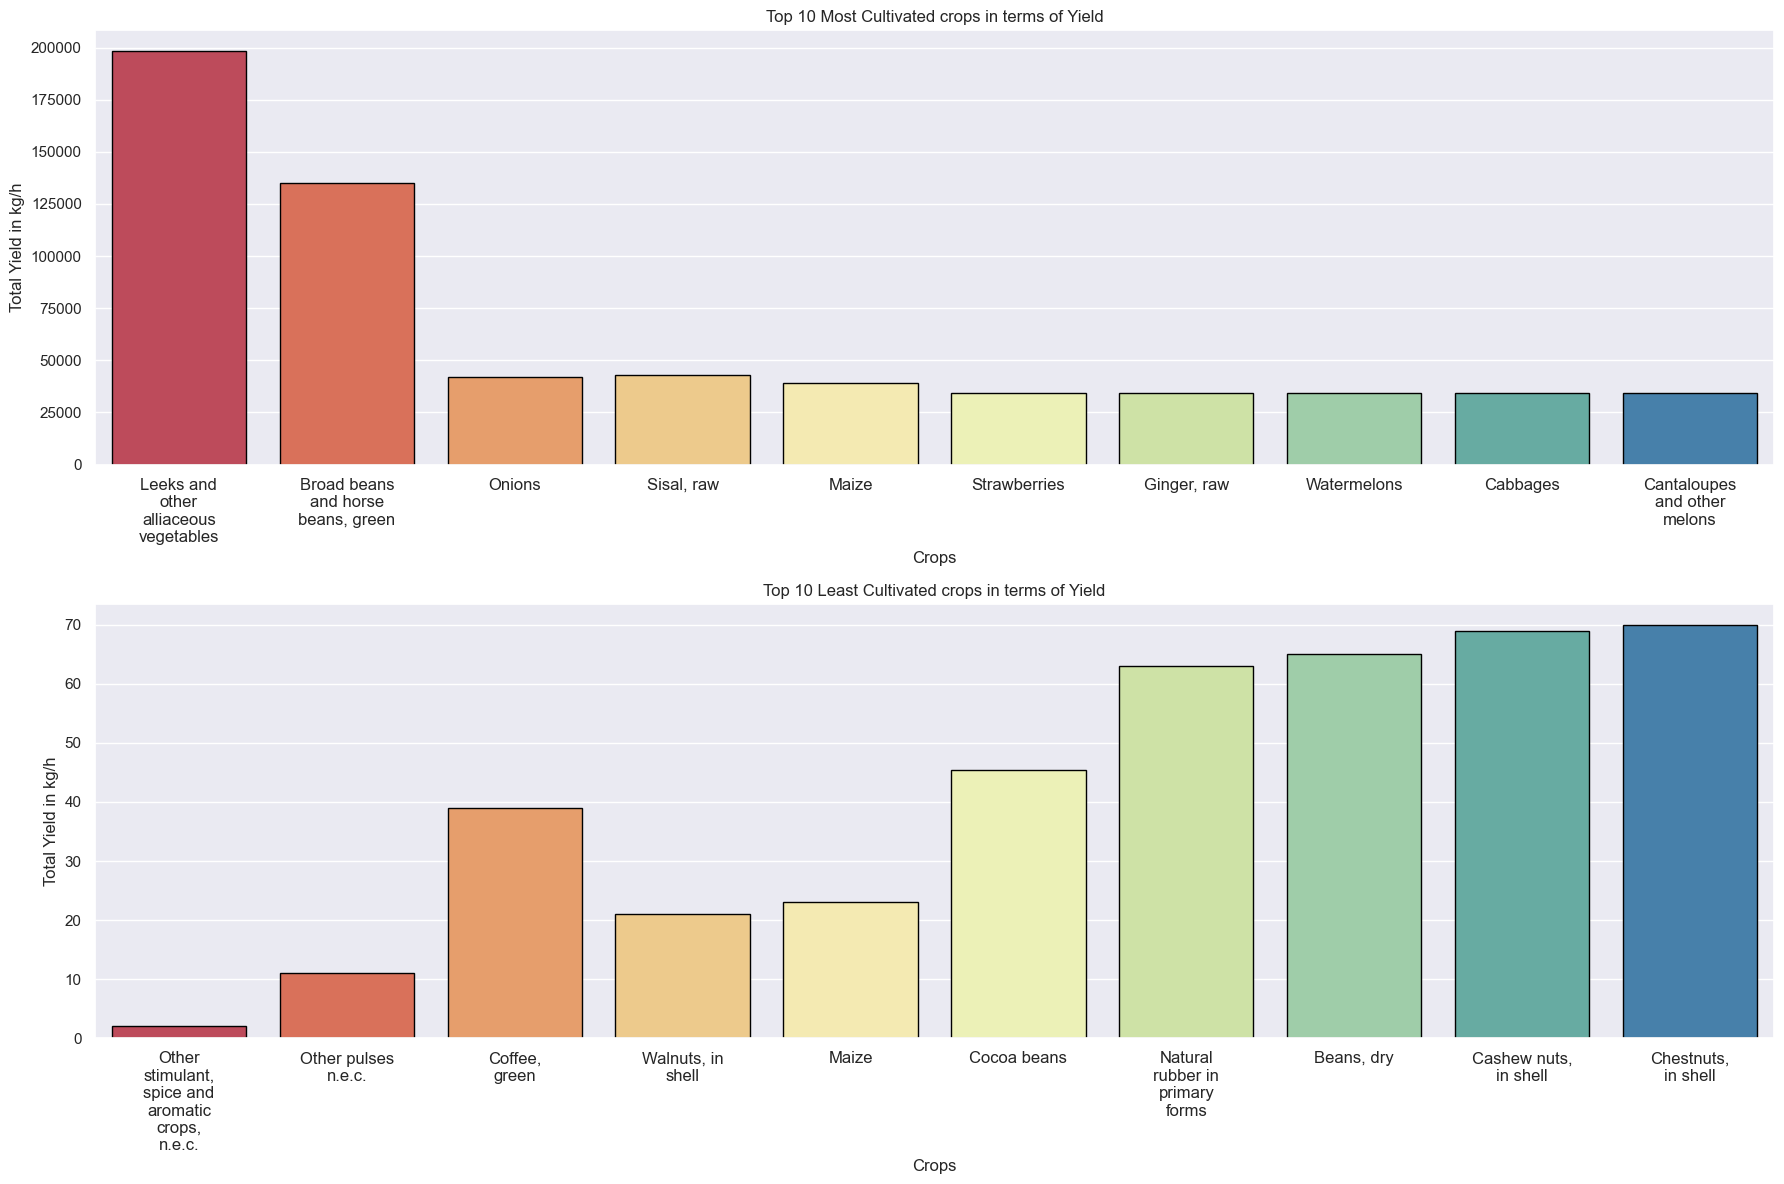

In [66]:
fig, ax = plt.subplots(2,1,figsize = (18,12))
sns.barplot(
    data = top_crops_yield,
    x = 'Item_wrapped',
    y = 'total_yield',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[0]
)
ax[0].set_title("Top 10 Most Cultivated crops in terms of Yield")
ax[0].tick_params(axis='x', labelrotation=0,labelsize=12)
# ax[0].set_yscale('log')
ax[0].set_ylabel('Total Yield in kg/h')
ax[0].set_xlabel('Crops')
# ax[0].yaxis.set_major_formatter(
    # ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}M'))

sns.barplot(
    data = bottom_crops_yield,
    x = 'Item_wrapped',
    y = 'total_yield',
    errorbar = None,
    palette = 'Spectral',
    edgecolor = 'black',
    ax = ax[1]
)
ax[1].set_title("Top 10 Least Cultivated crops in terms of Yield")
ax[1].tick_params(axis='x', labelrotation=0,labelsize=12)
ax[1].set_ylabel('Total Yield in kg/h')
ax[1].set_xlabel('Crops')

plt.tight_layout()
plt.show()

In [67]:
crop_trend = df[df['Item']=='Broad beans and horse beans, green'].drop(columns = ['Country','Category'])
crop_trend

,Item,Year,production_in_t,area_in_h,yield_in_kg_per_h,Item_wrapped
137,"Broad beans and horse beans, green",2019,133.0,27.0,4994.0,"Broad beans\nand horse\nbeans, green"
138,"Broad beans and horse beans, green",2020,130.0,26.0,4992.0,"Broad beans\nand horse\nbeans, green"
139,"Broad beans and horse beans, green",2021,128.0,26.0,4992.0,"Broad beans\nand horse\nbeans, green"
140,"Broad beans and horse beans, green",2022,130.0,26.0,4992.0,"Broad beans\nand horse\nbeans, green"
141,"Broad beans and horse beans, green",2023,129.0,26.0,4992.0,"Broad beans\nand horse\nbeans, green"
...,...,...,...,...,...,...
30748,"Broad beans and horse beans, green",2019,834.0,166.0,5015.0,"Broad beans\nand horse\nbeans, green"
30749,"Broad beans and horse beans, green",2020,820.0,164.0,5015.0,"Broad beans\nand horse\nbeans, green"
30750,"Broad beans and horse beans, green",2021,824.0,164.0,5015.0,"Broad beans\nand horse\nbeans, green"
30751,"Broad beans and horse beans, green",2022,826.0,165.0,5015.0,"Broad beans\nand horse\nbeans, green"


In [68]:
crop_trend_area = crop_trend.groupby('Year')['area_in_h'].sum().reset_index(name='total_area')
crop_trend_production = crop_trend.groupby('Year')['production_in_t'].sum().reset_index(name='total_production')
crop_trend_yield = crop_trend.groupby('Year')['yield_in_kg_per_h'].sum().reset_index(name='total_yield')


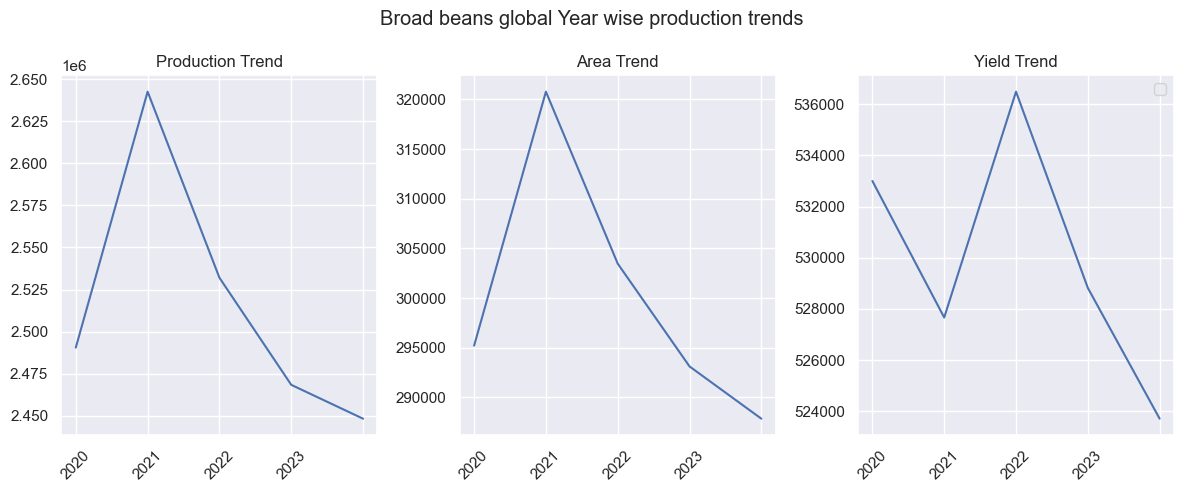

In [69]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].plot(crop_trend_production['Year'],crop_trend_production['total_production'])
ax[0].set_title('Production Trend')
# ax[0].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}M'))
ax[0].set_xticklabels(crop_trend_production['Year'].astype(int), rotation=45)


ax[1].plot(crop_trend_area['Year'],crop_trend_area['total_area'])
ax[1].set_title('Area Trend')
# ax[1].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[1].set_xticklabels(crop_trend_area['Year'].astype(int), rotation=45)


ax[2].plot(crop_trend_yield['Year'],crop_trend_yield['total_yield'])
ax[2].set_title('Yield Trend')
# ax[2].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[2].set_xticklabels(crop_trend_yield['Year'].astype(int), rotation=45)

plt.suptitle('Broad beans global Year wise production trends')
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
crop_trend2 = df[df['Item']=='Leeks and other alliaceous vegetables'].drop(columns = ['Country','Category'])
crop_trend2

,Item,Year,production_in_t,area_in_h,yield_in_kg_per_h,Item_wrapped
202,Leeks and other alliaceous vegetables,2019,36894.0,1531.0,24098.0,Leeks and\nother\nalliaceous\nvegetables
203,Leeks and other alliaceous vegetables,2020,36422.0,1484.0,24543.0,Leeks and\nother\nalliaceous\nvegetables
204,Leeks and other alliaceous vegetables,2021,36938.0,1526.0,24202.0,Leeks and\nother\nalliaceous\nvegetables
205,Leeks and other alliaceous vegetables,2022,39124.0,1550.0,25248.0,Leeks and\nother\nalliaceous\nvegetables
206,Leeks and other alliaceous vegetables,2023,46357.0,1743.0,26596.0,Leeks and\nother\nalliaceous\nvegetables
...,...,...,...,...,...,...
30829,Leeks and other alliaceous vegetables,2019,173.0,34.0,5133.0,Leeks and\nother\nalliaceous\nvegetables
30830,Leeks and other alliaceous vegetables,2020,174.0,34.0,5133.0,Leeks and\nother\nalliaceous\nvegetables
30831,Leeks and other alliaceous vegetables,2021,173.0,34.0,5133.0,Leeks and\nother\nalliaceous\nvegetables
30832,Leeks and other alliaceous vegetables,2022,173.0,34.0,5133.0,Leeks and\nother\nalliaceous\nvegetables


In [71]:
crop_trend2_area = crop_trend2.groupby('Year')['area_in_h'].sum().reset_index(name='total_area')
crop_trend2_production = crop_trend2.groupby('Year')['production_in_t'].sum().reset_index(name='total_production')
crop_trend2_yield = crop_trend2.groupby('Year')['yield_in_kg_per_h'].sum().reset_index(name='total_yield')

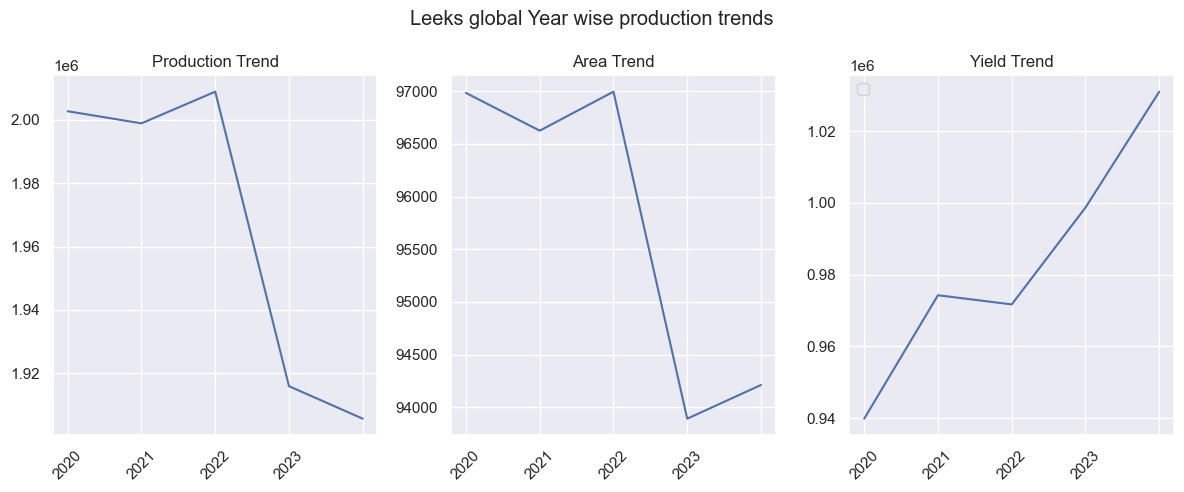

In [72]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].plot(crop_trend2_production['Year'],crop_trend2_production['total_production'])
ax[0].set_title('Production Trend')
# ax[0].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e5:.0f}M'))
ax[0].set_xticklabels(crop_trend2_production['Year'].astype(int), rotation=45)


ax[1].plot(crop_trend2_area['Year'],crop_trend2_area['total_area'])
ax[1].set_title('Area Trend')
# ax[1].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax[1].set_xticklabels(crop_trend2_area['Year'].astype(int), rotation=45)


ax[2].plot(crop_trend2_yield['Year'],crop_trend2_yield['total_yield'])
ax[2].set_title('Yield Trend')
# ax[2].yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
# ax[2].set_yscale('log')
ax[2].set_xticklabels(crop_trend2_yield['Year'].astype(int), rotation=45)

plt.suptitle('Leeks global Year wise production trends')
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
scatter_df = df[['Category','Year','production_in_t','area_in_h','yield_in_kg_per_h']]
scatter_df = scatter_df[scatter_df['Year']==2023]
scatter_df

,Category,Year,production_in_t,area_in_h,yield_in_kg_per_h
5,Spices,2023,17909.0,25439.0,704.0
11,Fruits,2023,155429.0,22008.0,7062.0
16,Fruits,2023,60651.0,10228.0,5930.0
21,Cereals,2023,1824.0,1142.0,1598.0
26,Seeds,2023,1000.0,1000.0,1000.0
...,...,...,...,...,...
30986,Fruits,2023,13467.0,1778.0,7573.0
30991,Cash crops,2023,66219.0,5662.0,11695.0
30995,Vegetables,2023,459036.0,20393.0,22510.0
31000,Fruits,2023,10.0,23.0,428.0


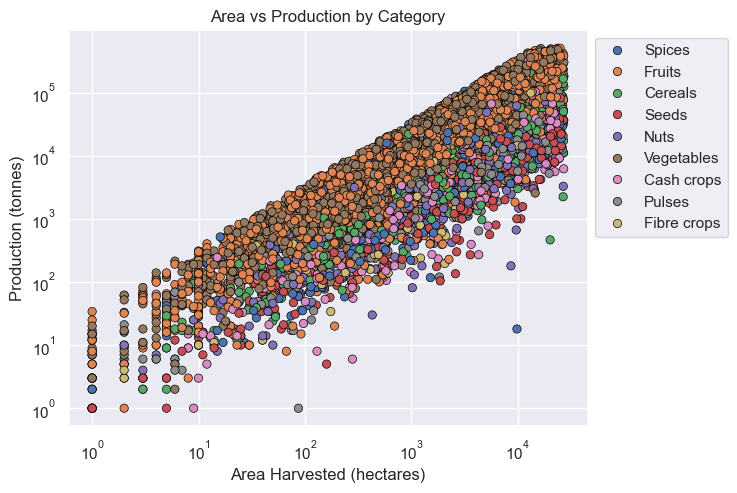

In [74]:
sns.set_theme(style='darkgrid')
sns.scatterplot(
    data = scatter_df,
    x = 'area_in_h',
    y = 'production_in_t',
    hue = 'Category',
    edgecolor = 'black'
)
plt.tight_layout()
plt.title("Area vs Production by Category")
plt.xlabel("Area Harvested (hectares)")
plt.ylabel("Production (tonnes)")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor = (1,1))
plt.show()


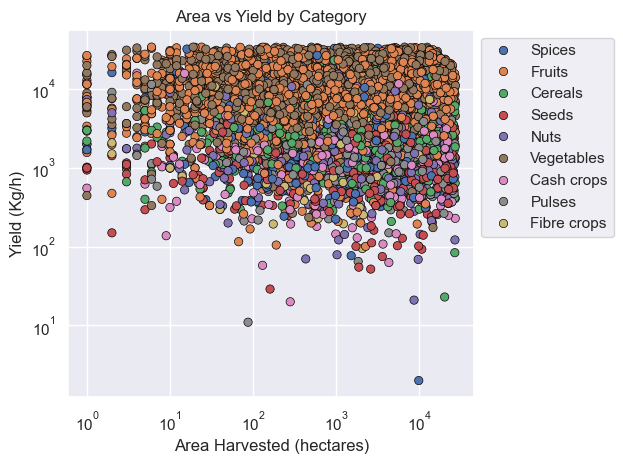

In [75]:
sns.set_theme(style='darkgrid')
sns.scatterplot(
    data = scatter_df,
    x = 'area_in_h',
    y = 'yield_in_kg_per_h',
    hue = 'Category',
    edgecolor = 'black'
)

plt.title("Area vs Yield by Category")
plt.xlabel("Area Harvested (hectares)")
plt.ylabel("Yield (Kg/h)")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor = (1,1))
plt.tight_layout()
plt.show()


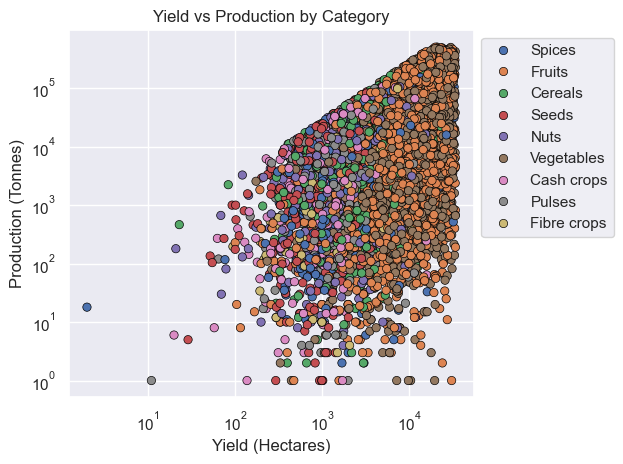

In [76]:
sns.set_theme(style='darkgrid')
sns.scatterplot(
    data = scatter_df,
    x = 'yield_in_kg_per_h',
    y = 'production_in_t',
    hue = 'Category',
    edgecolor = 'black'
)

plt.title("Yield vs Production by Category")
plt.xlabel("Yield (Hectares)")
plt.ylabel("Production (Tonnes)")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor = (1,1))
plt.tight_layout()
plt.show()

In [77]:
df

,Country,Item,Year,production_in_t,area_in_h,yield_in_kg_per_h,Category,Item_wrapped
0,Afghanistan,"Almonds, in shell",2020,39307.0,22134.0,1776.0,Nuts,"Almonds, in\nshell"
1,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2019,17808.0,25293.0,704.0,Spices,"Anise,\nbadian,\ncoriander,\ncumin,\ncaraway,\..."
2,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2020,17966.0,25558.0,703.0,Spices,"Anise,\nbadian,\ncoriander,\ncumin,\ncaraway,\..."
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2021,17876.0,25357.0,705.0,Spices,"Anise,\nbadian,\ncoriander,\ncumin,\ncaraway,\..."
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2022,17883.0,25403.0,704.0,Spices,"Anise,\nbadian,\ncoriander,\ncumin,\ncaraway,\..."
...,...,...,...,...,...,...,...,...
31001,Zimbabwe,Watermelons,2019,92975.0,3719.0,25000.0,Fruits,Watermelons
31002,Zimbabwe,Watermelons,2021,139000.0,4430.0,31377.0,Fruits,Watermelons
31003,Zimbabwe,Watermelons,2022,162100.0,4790.0,33841.0,Fruits,Watermelons
31004,Zimbabwe,Watermelons,2023,150600.0,4610.0,32668.0,Fruits,Watermelons


In [78]:
pie_df = df[['Category','Year','production_in_t','area_in_h','yield_in_kg_per_h']]
pie_2020_df = scatter_df[scatter_df['Year']==2020]
pie_2021_df = scatter_df[scatter_df['Year']==2021]
pie_2022_df = scatter_df[scatter_df['Year']==2022]
pie_2023_df = scatter_df[scatter_df['Year']==2023]
pie_df

,Category,Year,production_in_t,area_in_h,yield_in_kg_per_h
0,Nuts,2020,39307.0,22134.0,1776.0
1,Spices,2019,17808.0,25293.0,704.0
2,Spices,2020,17966.0,25558.0,703.0
3,Spices,2021,17876.0,25357.0,705.0
4,Spices,2022,17883.0,25403.0,704.0
...,...,...,...,...,...
31001,Fruits,2019,92975.0,3719.0,25000.0
31002,Fruits,2021,139000.0,4430.0,31377.0
31003,Fruits,2022,162100.0,4790.0,33841.0
31004,Fruits,2023,150600.0,4610.0,32668.0


In [79]:
pie_df1 = pie_df.groupby('Category')['production_in_t'].sum().reset_index(name='total_production')
pie_df1

,Category,total_production
0,Cash crops,20900405.0
1,Cereals,50271091.0
2,Fibre crops,4004961.0
3,Fruits,476059842.0
4,Nuts,13662034.0
5,Pulses,15961730.0
6,Seeds,13752533.0
7,Spices,33011687.0
8,Vegetables,444174031.0


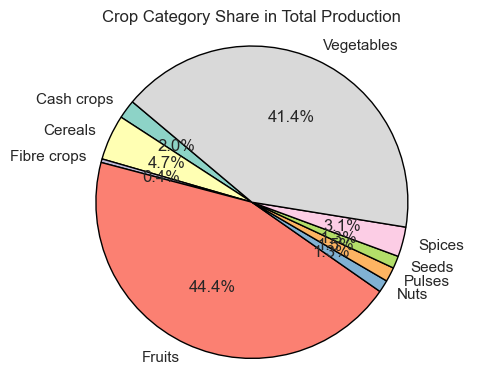

In [80]:
plt.figure(figsize=(5, 4))
plt.pie(
    pie_df1['total_production'],
    labels=pie_df1['Category'],
    autopct='%1.1f%%',           # Display percentage
    startangle=140,              # Start angle of pie chart
    colors=plt.cm.Set3.colors,   # Use a matplotlib colormap for colors
    wedgeprops={'edgecolor': 'black'}  # Adds black edges
)

plt.title('Crop Category Share in Total Production')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [81]:
import plotly.io as pio
pio.renderers.default = 'browser'

pie_df1 = pie_df.groupby('Category')['production_in_t'].sum().reset_index(name='total_production')
pie_df1

fig = px.pie(pie_df1, names=pie_df1['Category'],values=pie_df1['total_production'], hole=0.5)
fig.show()

In [82]:
pie_df2 = pie_df.groupby('Category')['area_in_h'].sum().reset_index(name='total_area')
pie_df2

fig = px.pie(pie_df2, names=pie_df2['Category'],values=pie_df2['total_area'], hole=0.5)
fig.show()

In [83]:
pie_df3 = pie_df.groupby('Category')['yield_in_kg_per_h'].sum().reset_index(name='total_yield')
pie_df3

fig = px.pie(pie_df3, names=pie_df3['Category'],values=pie_df3['total_yield'], hole=0.5)
fig.show()